In [1]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse


In [4]:
BIAS_DATA = "../data/bias_scores.csv"
bias_df = pd.read_csv(BIAS_DATA)
bias_df.head()


,domain,score,fb_score,mturk_score,budak_score,allsides_score,allsides_score_community,pew_score
0,bitly.com,0.0543,NaN,NaN,NaN,NaN,NaN,NaN
1,youtube.com,0.1282,0.0634,0.000000,NaN,NaN,NaN,NaN
2,instagram.com,0.1427,NaN,0.000000,NaN,NaN,NaN,NaN
3,facebook.com,0.1132,NaN,-0.083333,NaN,NaN,NaN,NaN
4,ow.ly,0.0882,NaN,0.000000,NaN,NaN,NaN,NaN


In [81]:
url = 'www.py4u.net'
# url = 'https://www.google.com'
print(url)

www_re = re.compile(r"(www\.)?")
url = www_re.sub('', url)
print(url)

www.py4u.net
py4u.net


In [88]:
import re



def get_bias_score(urls):
    '''
    pass in a list urls return the mean media bias score
    or nan if none if the urls is included in the media bias
    database
    '''
    scores = []

    # get path of the url
    urls = [urlparse(u).path for u in urls]
    # remove www if there is
    www_re = re.compile(r"(www\.)?")
    urls = [www_re.sub('', u) for u in urls]
    for u in urls:
        # takes the mean of the matched results
        ss = bias_df[bias_df['domain'].str.match(u)]['score']
        if not ss.empty:
            scores.append(ss.mean())

    if scores:
        return np.nanmean(scores)
    else:
        return np.nan



print(get_bias_score(["www.not_exist.com", "www.xx.com"]))
print(get_bias_score(["google.com", "www.politicio.com"]))

nan
0.16504285714285713


In [50]:
# QUOTE_FILE = '../data/quotes_mentions_USA_compact.json.bz2'
QUOTE_FILE = '../data/quotes_mentions_USA_ML.json.bz2'
df = pd.read_json(QUOTE_FILE, lines=True, compression='bz2')


In [82]:
df.urls

0                                            [examiner.com]
1                                 [liveblog.irishtimes.com]
2                      [feeds.foxnews.com, www.foxnews.com]
3                                          [hottytoddy.com]
4                          [www.politico.com, politico.com]
                                ...                        
450431            [www.irishtimes.com, full.gulf-times.com]
450432                  [www.thenewcivilrightsmovement.com]
450433    [commondreams.org, www.commondreams.org, www.r...
450434                             [uspolitics.einnews.com]
450435            [www.breitbart.com, www.prisonplanet.com]
Name: urls, Length: 450436, dtype: object

<AxesSubplot:ylabel='Count'>

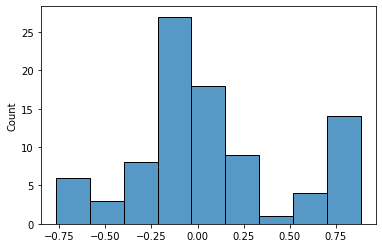

In [91]:
import seaborn as sns

# see the distribution of first 100 quotations
scores = [get_bias_score(urls) for urls in df['urls'].iloc[:100]]
sns.histplot(scores)

In [92]:
import os, time, bz2

READ_FILE = '../data/quotes_mentions_USA_ML.json.bz2'
SAVE_FILE = '../data/quotes_mentions_USA_ML_bias.json.bz2'

CHUNKSIZE = 3000

try:
    os.remove(SAVE_FILE)
except:
    pass

total_time,total_mentions,chunk_number,nb_quote=0,0,0,0
mentions=[]


with bz2.open(SAVE_FILE, 'wb') as bz_writer:
    with pd.read_json(READ_FILE, lines=True, chunksize=CHUNKSIZE, compression='bz2' ) as df_reader:
        for chunk in df_reader:
            t1=time.time()

            # get bias
            bias = [get_bias_score(urls) for urls in chunk['urls']]
            chunk["source_bias"] = bias

            chunk.to_json(path_or_buf=bz_writer,orient='records',lines=True)
            mentions = len(chunk)
            total_mentions += mentions
            t2=time.time()
            dt=t2-t1
            total_time+=dt
            chunk_number += 1
            print("Dumped {} quotations out of {} quotations [quotations/s: {:.2f}]".format(mentions, CHUNKSIZE, CHUNKSIZE / dt))

Dumped 3000 quotations out of 3000 quotations [quotations/s: 56.15]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 57.29]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 55.21]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 52.47]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 55.42]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 57.64]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 57.01]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 61.62]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 63.00]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 53.08]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 55.31]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 55.17]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 56.85]
Dumped 3000 quotations out of 3000 quotations [quotations/s: 58.17]
Dumped 3000 quotations out of 3000 quotations [q

In [93]:
df = pd.read_json(SAVE_FILE, lines=True, compression='bz2' )
df.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,topic_index,topic_scores,sentiment,source_bias
0,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,Q359442,2015-10-25 14:12:35,1,E,[Bill Clinton],[Q1124],[examiner.com],8,0.818588,-0.4822,0.1168
1,2015-08-07-005048,All we ╒ re asking for here is a discussion an...,John Boehner,Q11702,2015-08-07 12:52:52,1,E,[Barack Obama],[Q76],[liveblog.irishtimes.com],8,0.774811,0.0000,NaN
2,2015-10-01-005722,An email included in the latest tranche of Cli...,Hillary Clinton,Q6294,2015-10-01 14:56:48,2,E,[Bill Clinton],[Q1124],"[feeds.foxnews.com, www.foxnews.com]",4,0.368826,-0.2732,0.7295
3,2015-11-17-006368,"and in fact, Secretary of State Kerry was earl...",Phil Bryant,Q887898,2015-11-17 20:03:05,1,E,[John Kerry],[Q22316],[hottytoddy.com],1,0.774721,0.0258,NaN
4,2015-02-14-014011,I have fought Obamacare from Day One and will ...,John Cornyn,Q719568,2015-02-14 21:01:51,2,E,[Barack Obama],[Q76],"[www.politico.com, politico.com]",2,0.389230,-0.1280,-0.1914


<AxesSubplot:xlabel='source_bias', ylabel='Count'>

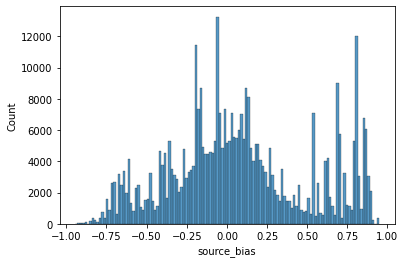

In [95]:
sns.histplot(df['source_bias'])